<a href="https://colab.research.google.com/github/celisa/Reinforcement-Learning-Repo/blob/main/hw2/dqn_sb3_Elisa_Chen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elisa Chen 
# AIPI 531 - HW2
Net ID: eyc11

# DQN and Double DQN with Stable-Baselines3

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Double Q-Learning: https://paperswithcode.com/method/double-q-learning


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines3.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.


## Introduction

In this notebook, we will study DQN using Stable-Baselines3 and then see how to reduce value overestimation with double DQN.

## Installation

We will install master version of SB3.

In [2]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra] pyglet==1.5.27

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  freeglut3 freeglut3-dev xvfb
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 977 kB of archives.
After this operation, 3,350 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3-dev amd64 2.8.1-3 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 977 kB in 1s (924 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 128126 files and directories currently installed.)

Import DQN and evaluation helper

In [3]:
import gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

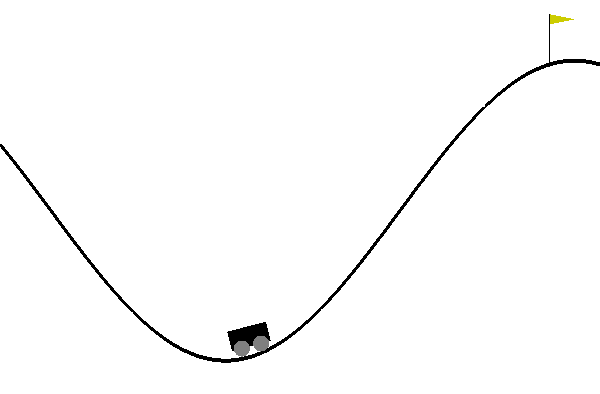


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [4]:
env = gym.make("MountainCar-v0")

Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [5]:
tensorboard_log = "data/tb/"

In [6]:
dqn_model = DQN("MlpPolicy",
            env,
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [7]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [8]:
# Optional: Monitor training in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir $tensorboard_log

We will first train the agent until convergence and then analyse the learned q-value function.

In [9]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 156      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 3.35e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 186      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.39e-

Evaluate after training, the mean episodic reward should have improved.

In [10]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-117.90 +/- 34.50


### Prepare video recording

In [11]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [12]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [13]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=False)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

## Visualize trained agent

In [14]:
record_video('MountainCar-v0', dqn_model, video_length=500, prefix='dqn-mountaincar')

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [15]:
show_videos('videos', prefix='dqn')

## Visualize Q-values

### Exercise (5 minutes): Retrieve q-values

The function will be used to retrieve the learned q-values for a given state (`observation` in the code).

The q-network from SB3 DQN can be accessed via `model.q_net` and is a PyTorch module (you can therefore call `.forward()` on it).

You need to convert the observation to a PyTorch tensor and then convert the resulting q-values to numpy array.

Note: It is recommended to use `with th.no_grad():` context to save computation and memory

In [16]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    # Retrieve q-values for the given observation and convert them to numpy
    with th.no_grad():
      ## Create a tensor of the observation numpy array
      observation_tensor = th.from_numpy(obs).unsqueeze(0)

      ## Pass the observation through the Q network to fetch the Q Values
      q_values = dqn_model.q_net(observation_tensor)
      
      ## Convert Q values tensor to numpy array
      q_values = q_values.squeeze().numpy()
    
    ### END OF YOUR CODE
    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

### Q-values for the initial state

Let's reset the environment to start a new episode:

In [17]:
obs = env.reset()

we plot the rendered environment to visualize it

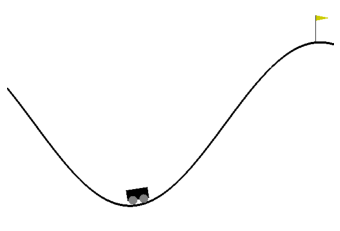

In [18]:
plt.axis('off')
plt.imshow(env.render(mode="rgb_array"))

### Exercise (5 minutes): predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [19]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [20]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`

q_value_left, q_value_nothing, q_value_right = get_q_values(dqn_model, obs)

### END OF YOUR CODE

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values 
# when following a greedy strategy

action = np.argmax(get_q_values(dqn_model, obs))

## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-44.06 nothing=-39.24 right=-34.36
Action taken by the greedy policy in the initial state: Right


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [21]:
initial_q_value = get_q_values(dqn_model, obs).max()
print(f"Inital q value: {initial_q_value}")

Inital q value: -34.3642463684082


## Step until the end of the episode



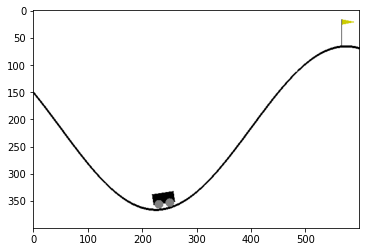

Q-value of the current state left=-44.06 nothing=-39.24 right=-34.36
Action: Right


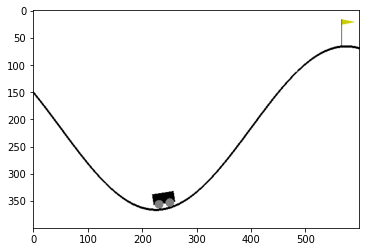

Q-value of the current state left=-43.37 nothing=-38.21 right=-32.78
Action: Right


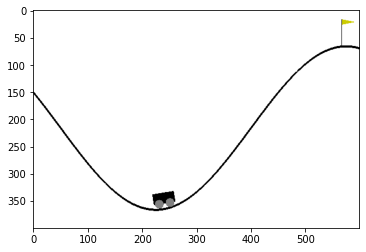

Q-value of the current state left=-43.09 nothing=-37.45 right=-31.43
Action: Right


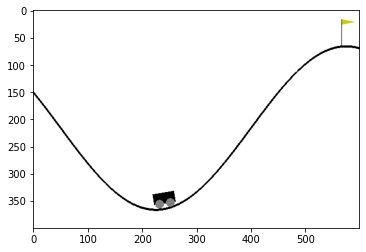

Q-value of the current state left=-42.93 nothing=-37.07 right=-30.82
Action: Right


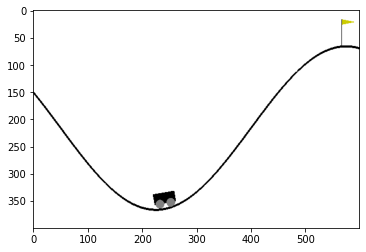

Q-value of the current state left=-42.83 nothing=-37.06 right=-31.03
Action: Right


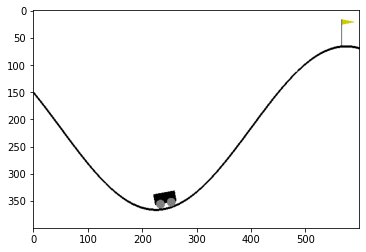

Q-value of the current state left=-42.87 nothing=-37.20 right=-31.44
Action: Right


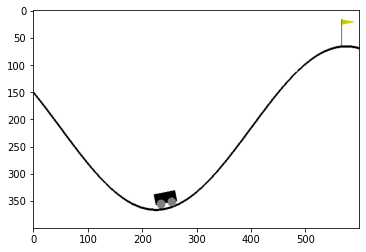

Q-value of the current state left=-42.61 nothing=-36.97 right=-31.40
Action: Right


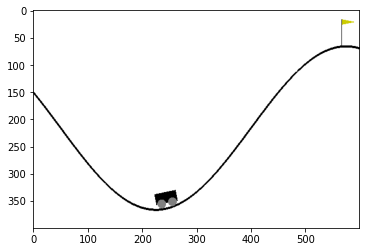

Q-value of the current state left=-41.93 nothing=-36.44 right=-31.28
Action: Right


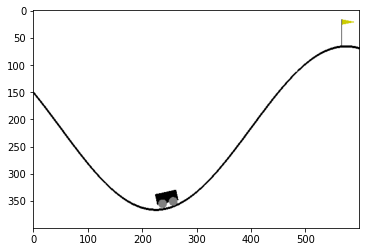

Q-value of the current state left=-40.99 nothing=-35.61 right=-30.92
Action: Right


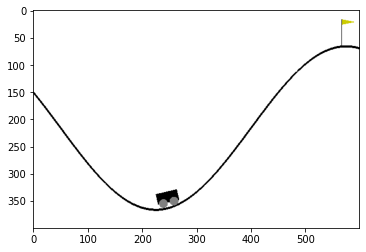

Q-value of the current state left=-40.11 nothing=-34.86 right=-30.68
Action: Right


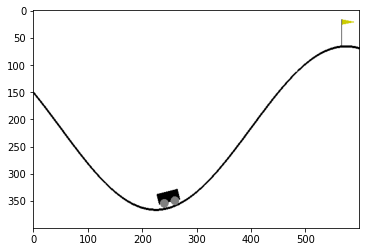

Q-value of the current state left=-39.31 nothing=-34.20 right=-30.59
Action: Right


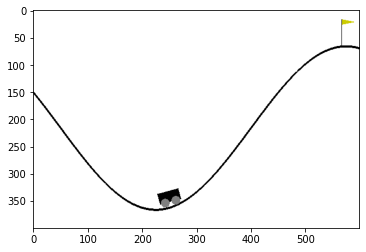

Q-value of the current state left=-38.57 nothing=-33.61 right=-30.61
Action: Right


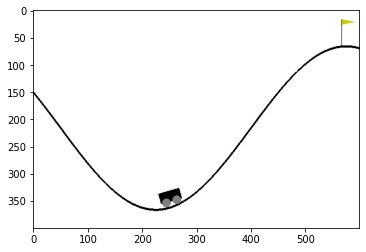

Q-value of the current state left=-36.12 nothing=-31.08 right=-28.74
Action: Right


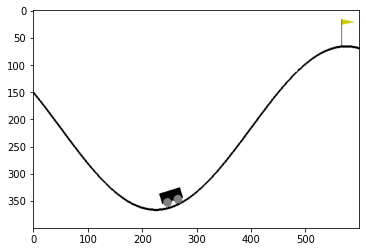

Q-value of the current state left=-33.01 nothing=-28.35 right=-26.50
Action: Right


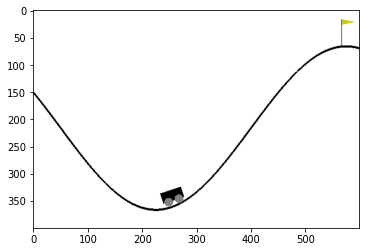

Q-value of the current state left=-29.69 nothing=-26.03 right=-24.45
Action: Right


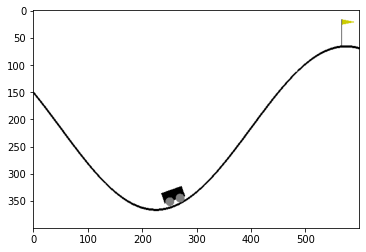

Q-value of the current state left=-26.30 nothing=-23.69 right=-22.38
Action: Right


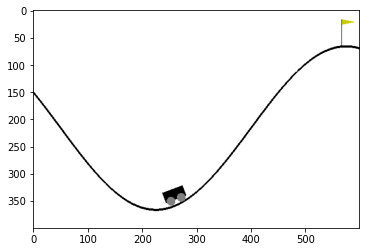

Q-value of the current state left=-23.34 nothing=-21.53 right=-20.90
Action: Right


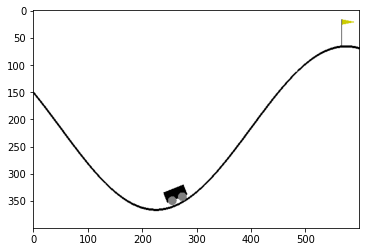

Q-value of the current state left=-20.71 nothing=-19.53 right=-19.85
Action: Nothing


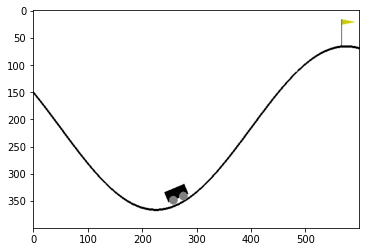

Q-value of the current state left=-20.14 nothing=-20.07 right=-21.07
Action: Nothing


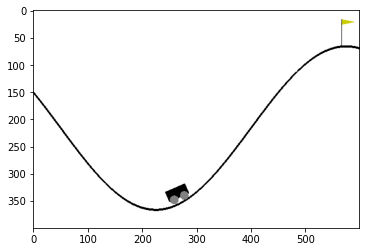

Q-value of the current state left=-19.96 nothing=-20.93 right=-22.51
Action: Left


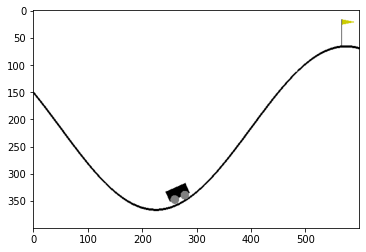

Q-value of the current state left=-21.39 nothing=-23.72 right=-25.44
Action: Left


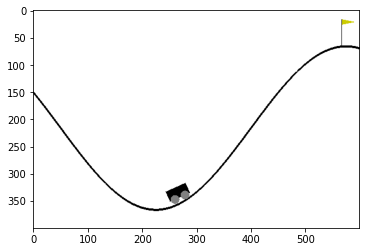

Q-value of the current state left=-18.45 nothing=-21.37 right=-22.37
Action: Left


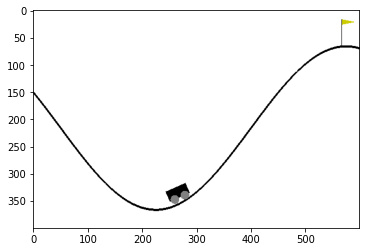

Q-value of the current state left=-15.25 nothing=-18.45 right=-18.35
Action: Left


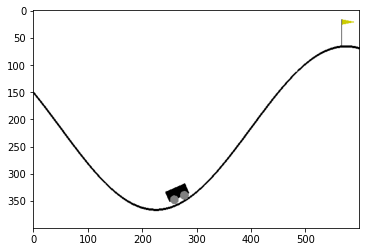

Q-value of the current state left=-12.89 nothing=-15.81 right=-14.33
Action: Left


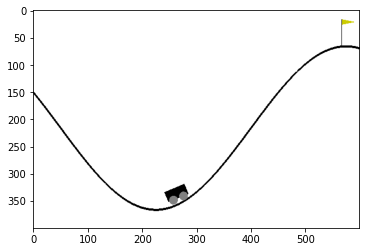

Q-value of the current state left=-11.39 nothing=-14.97 right=-13.94
Action: Left


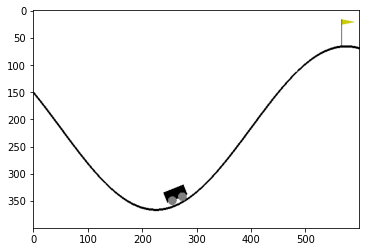

Q-value of the current state left=-6.29 nothing=-11.61 right=-12.64
Action: Left


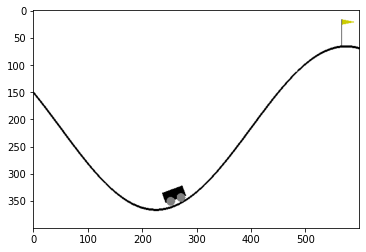

Q-value of the current state left=-1.21 nothing=-8.36 right=-11.49
Action: Left


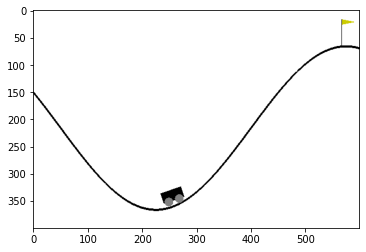

Q-value of the current state left=2.71 nothing=-6.30 right=-11.40
Action: Left


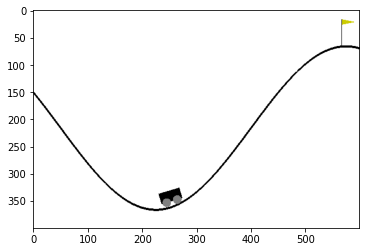

Q-value of the current state left=7.70 nothing=-3.00 right=-9.93
Action: Left


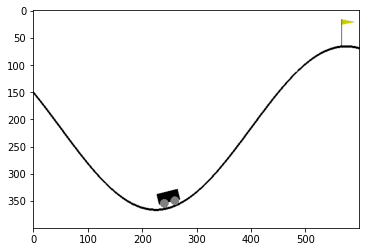

Q-value of the current state left=17.42 nothing=5.64 right=-2.69
Action: Left


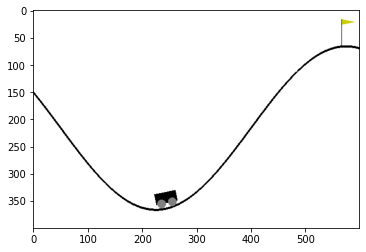

Q-value of the current state left=24.95 nothing=12.20 right=3.13
Action: Left


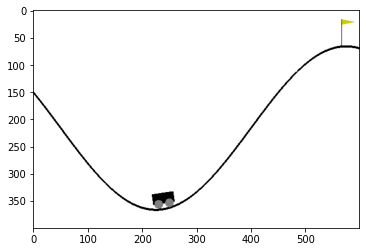

Q-value of the current state left=32.85 nothing=19.08 right=9.14
Action: Left


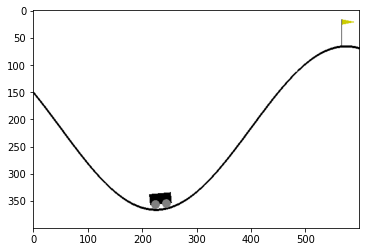

Q-value of the current state left=41.21 nothing=26.82 right=16.03
Action: Left


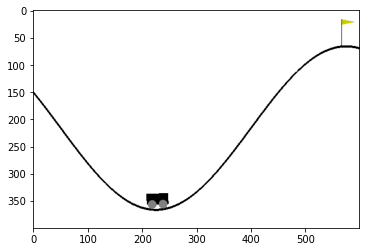

Q-value of the current state left=48.26 nothing=33.81 right=22.63
Action: Left


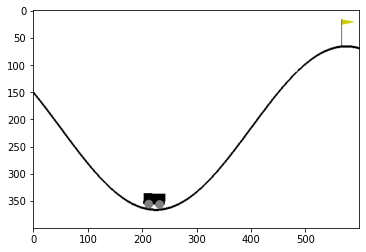

Q-value of the current state left=56.07 nothing=41.80 right=30.39
Action: Left


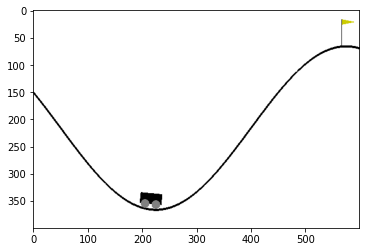

Q-value of the current state left=63.01 nothing=48.89 right=37.31
Action: Left


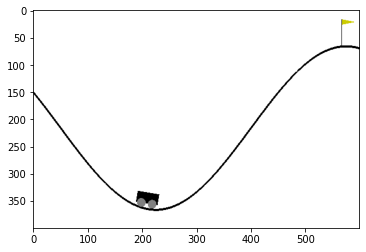

Q-value of the current state left=68.03 nothing=54.33 right=42.00
Action: Left


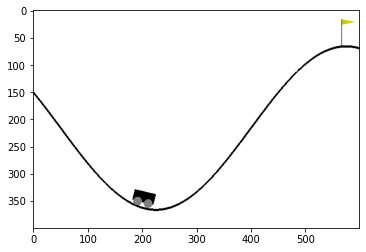

Q-value of the current state left=74.59 nothing=61.32 right=48.77
Action: Left


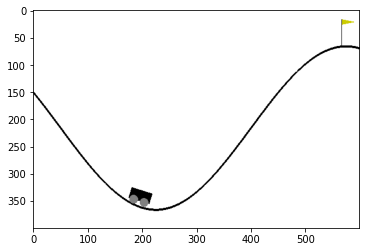

Q-value of the current state left=83.21 nothing=70.64 right=58.50
Action: Left


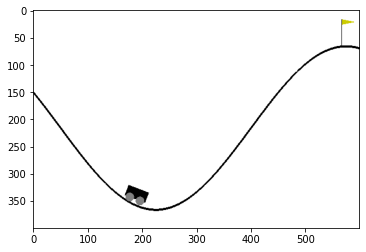

Q-value of the current state left=90.61 nothing=78.27 right=66.00
Action: Left


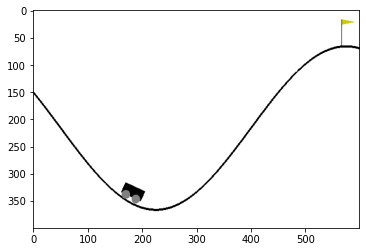

Q-value of the current state left=101.53 nothing=89.66 right=77.41
Action: Left


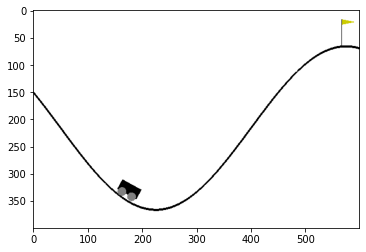

Q-value of the current state left=111.26 nothing=99.87 right=87.57
Action: Left


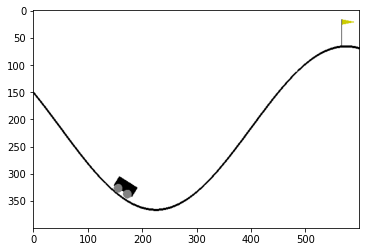

Q-value of the current state left=121.65 nothing=110.78 right=98.59
Action: Left


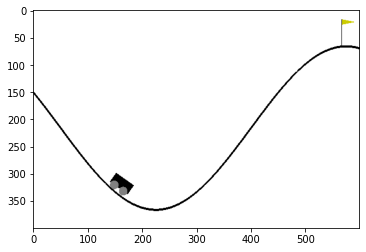

Q-value of the current state left=135.26 nothing=124.55 right=112.42
Action: Left


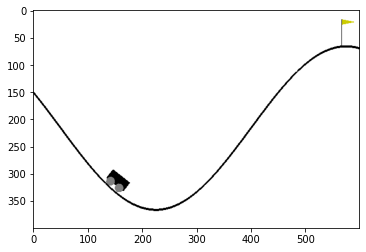

Q-value of the current state left=146.78 nothing=135.83 right=123.47
Action: Left


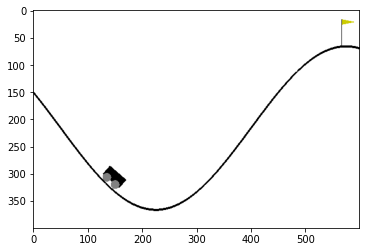

Q-value of the current state left=156.33 nothing=144.95 right=132.29
Action: Left


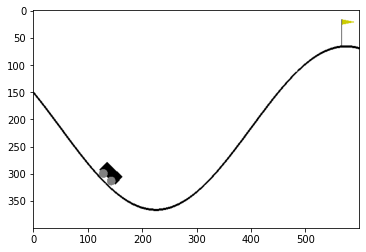

Q-value of the current state left=173.44 nothing=163.06 right=150.90
Action: Left


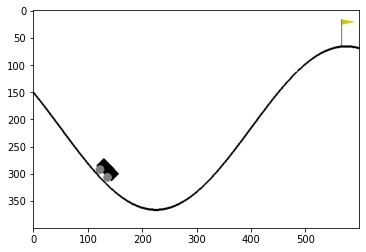

Q-value of the current state left=188.52 nothing=178.96 right=167.22
Action: Left


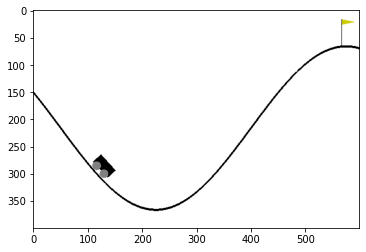

Q-value of the current state left=201.36 nothing=192.39 right=180.96
Action: Left


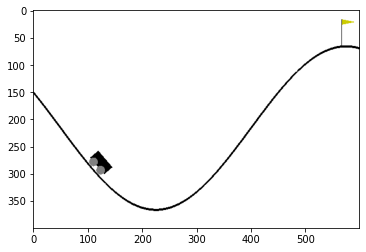

Q-value of the current state left=215.75 nothing=207.94 right=197.29
Action: Left


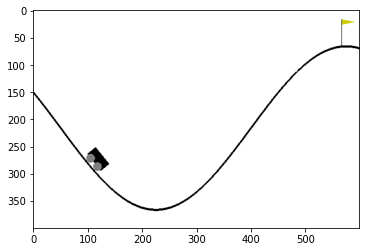

Q-value of the current state left=237.23 nothing=232.11 right=223.33
Action: Left


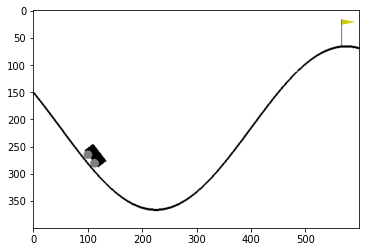

Q-value of the current state left=259.85 nothing=257.46 right=250.56
Action: Left


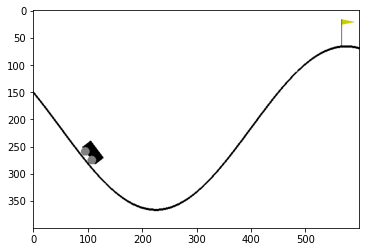

Q-value of the current state left=281.97 nothing=282.05 right=276.76
Action: Nothing


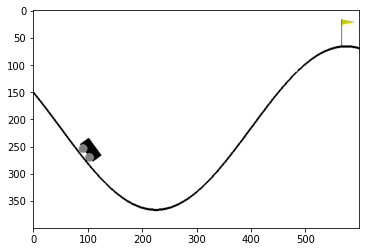

Q-value of the current state left=296.93 nothing=298.74 right=294.77
Action: Nothing


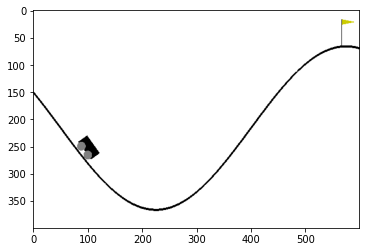

Q-value of the current state left=318.72 nothing=324.24 right=323.23
Action: Nothing


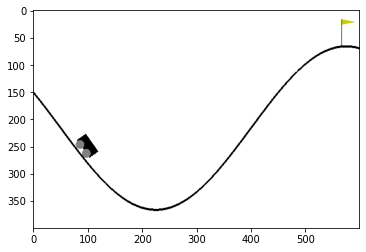

Q-value of the current state left=337.65 nothing=345.96 right=347.47
Action: Right


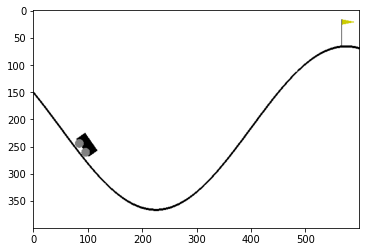

Q-value of the current state left=356.04 nothing=367.01 right=371.32
Action: Right


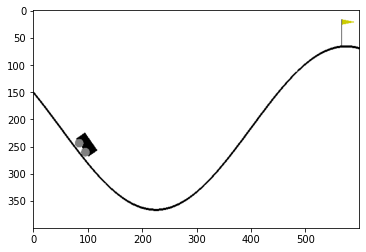

Q-value of the current state left=370.87 nothing=384.30 right=391.36
Action: Right


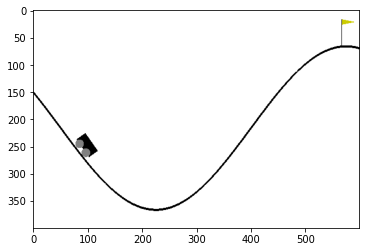

Q-value of the current state left=380.66 nothing=395.81 right=405.92
Action: Right


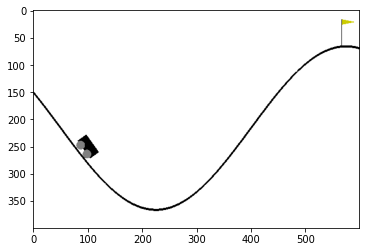

Q-value of the current state left=397.76 nothing=415.50 right=429.79
Action: Right


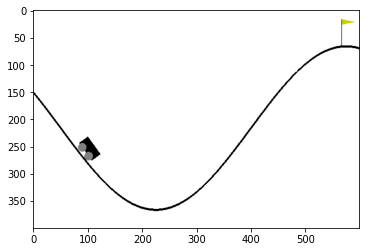

Q-value of the current state left=410.23 nothing=428.34 right=446.77
Action: Right


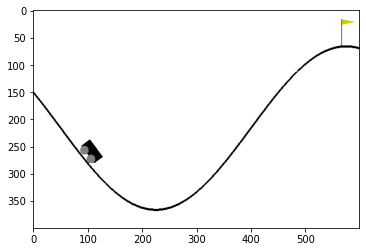

Q-value of the current state left=425.05 nothing=442.56 right=464.53
Action: Right


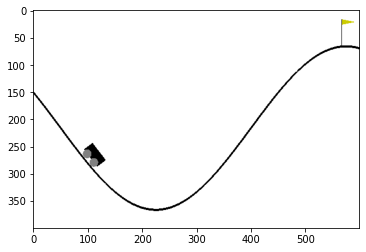

Q-value of the current state left=442.57 nothing=466.99 right=494.79
Action: Right


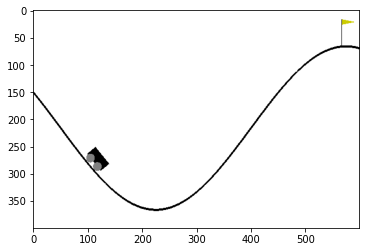

Q-value of the current state left=447.62 nothing=479.04 right=512.83
Action: Right


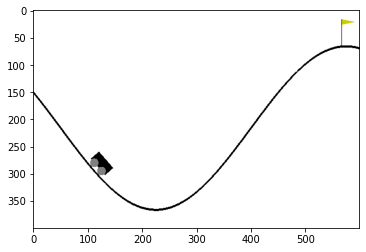

Q-value of the current state left=477.28 nothing=512.19 right=550.95
Action: Right


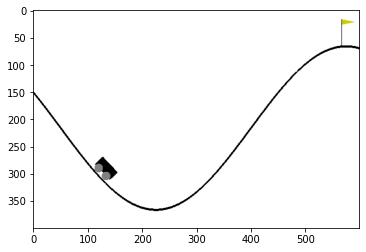

Q-value of the current state left=510.57 nothing=547.05 right=590.48
Action: Right


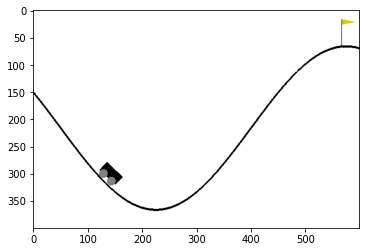

Q-value of the current state left=534.90 nothing=572.45 right=621.19
Action: Right


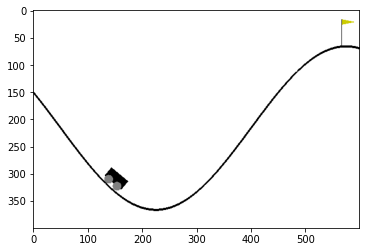

Q-value of the current state left=562.36 nothing=602.30 right=657.03
Action: Right


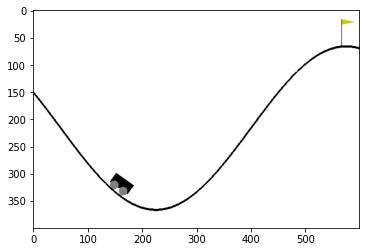

Q-value of the current state left=597.21 nothing=641.60 right=703.08
Action: Right


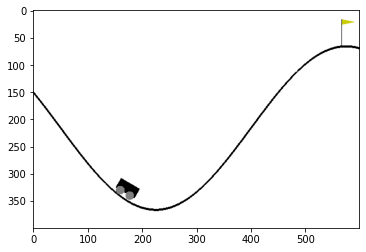

Q-value of the current state left=617.98 nothing=666.68 right=734.68
Action: Right


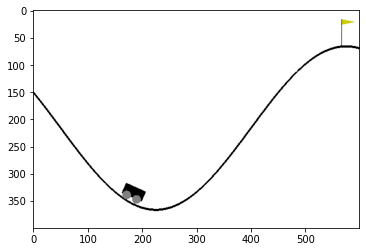

Q-value of the current state left=640.44 nothing=694.50 right=768.60
Action: Right


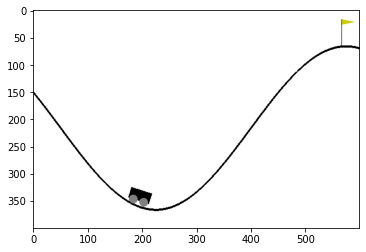

Q-value of the current state left=652.38 nothing=710.47 right=788.99
Action: Right


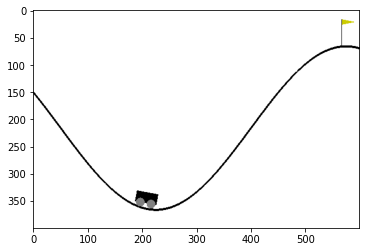

Q-value of the current state left=692.87 nothing=759.40 right=844.75
Action: Right


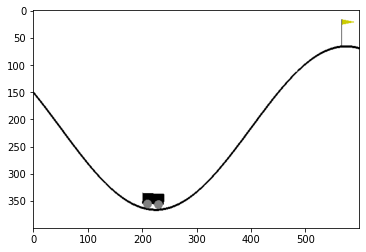

Q-value of the current state left=710.86 nothing=782.78 right=873.25
Action: Right


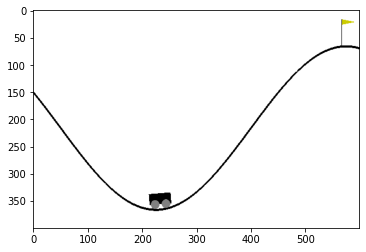

Q-value of the current state left=742.95 nothing=821.71 right=918.05
Action: Right


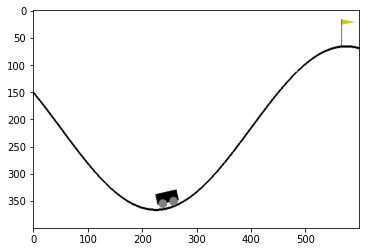

Q-value of the current state left=782.44 nothing=871.90 right=973.45
Action: Right


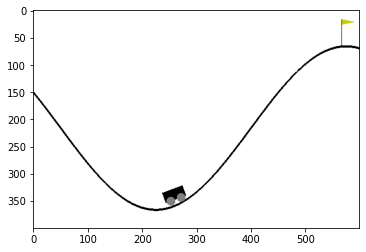

Q-value of the current state left=800.65 nothing=898.21 right=1003.45
Action: Right


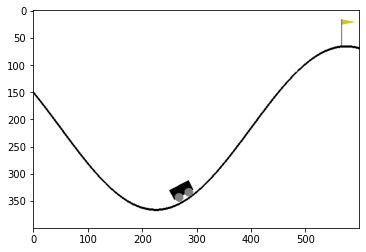

Q-value of the current state left=842.73 nothing=954.32 right=1062.60
Action: Right


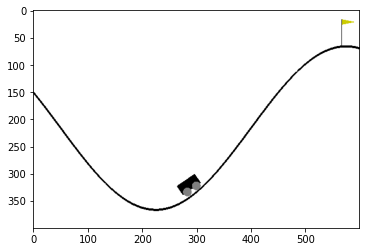

Q-value of the current state left=877.31 nothing=1000.61 right=1113.90
Action: Right


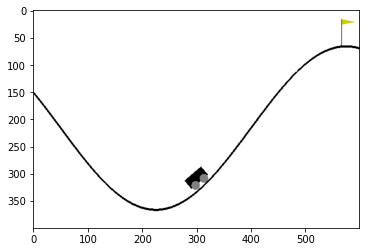

Q-value of the current state left=933.44 nothing=1059.55 right=1174.23
Action: Right


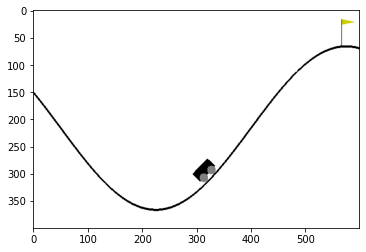

Q-value of the current state left=989.99 nothing=1115.21 right=1231.41
Action: Right


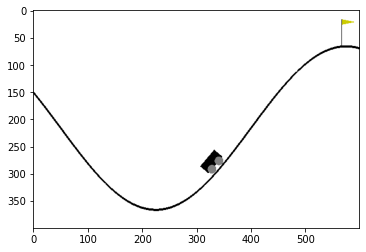

Q-value of the current state left=1041.76 nothing=1162.32 right=1275.80
Action: Right


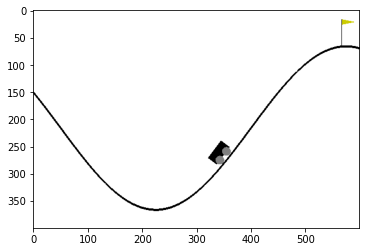

Q-value of the current state left=1103.18 nothing=1216.67 right=1326.70
Action: Right


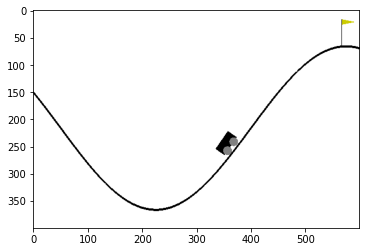

Q-value of the current state left=1180.24 nothing=1291.40 right=1400.54
Action: Right


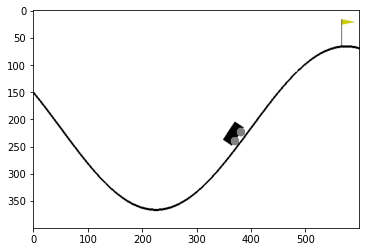

Q-value of the current state left=1252.46 nothing=1361.68 right=1469.82
Action: Right


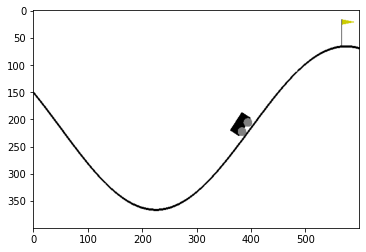

Q-value of the current state left=1312.91 nothing=1418.29 right=1523.68
Action: Right


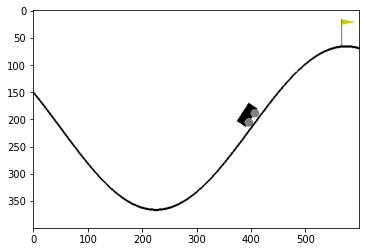

Q-value of the current state left=1380.93 nothing=1482.63 right=1583.95
Action: Right


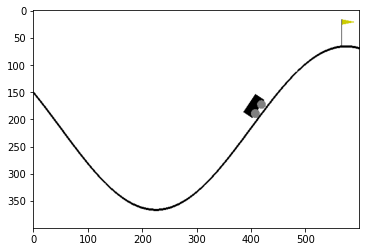

Q-value of the current state left=1452.67 nothing=1551.68 right=1649.72
Action: Right


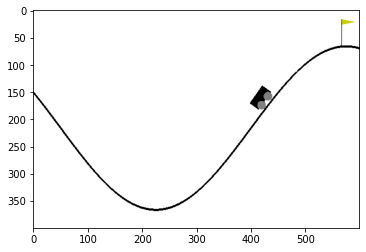

Q-value of the current state left=1522.92 nothing=1619.08 right=1714.21
Action: Right


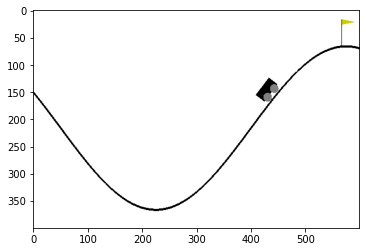

Q-value of the current state left=1593.95 nothing=1688.72 right=1781.75
Action: Right


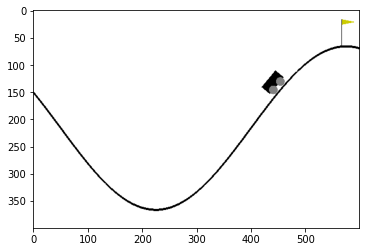

Q-value of the current state left=1664.00 nothing=1758.39 right=1849.58
Action: Right


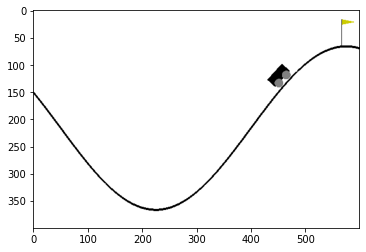

Q-value of the current state left=1746.08 nothing=1841.12 right=1929.89
Action: Right


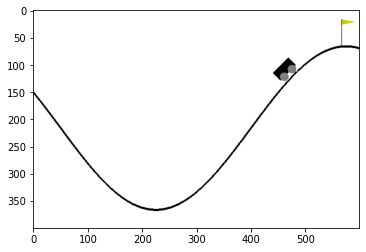

Q-value of the current state left=1836.21 nothing=1930.98 right=2016.99
Action: Right


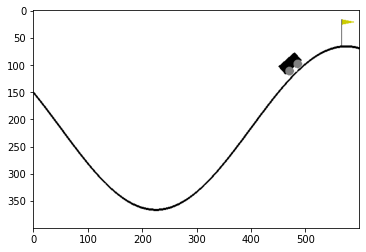

Q-value of the current state left=1928.27 nothing=2020.14 right=2102.75
Action: Right


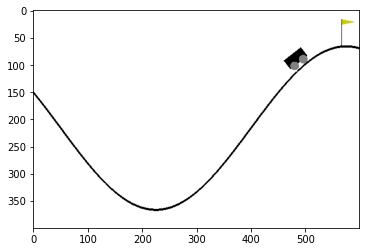

Q-value of the current state left=2021.98 nothing=2108.68 right=2187.42
Action: Right


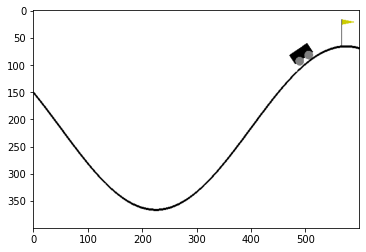

Q-value of the current state left=2115.41 nothing=2197.63 right=2273.40
Action: Right


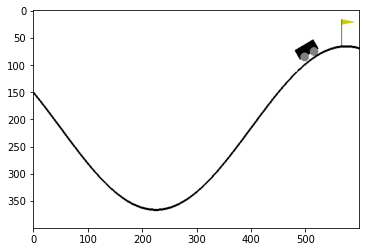

Q-value of the current state left=2209.14 nothing=2288.16 right=2361.04
Action: Right


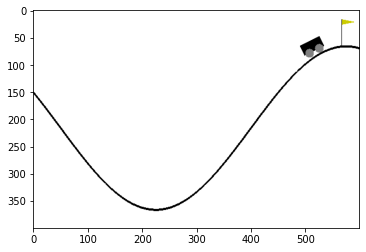

Q-value of the current state left=2301.05 nothing=2379.16 right=2450.21
Action: Right


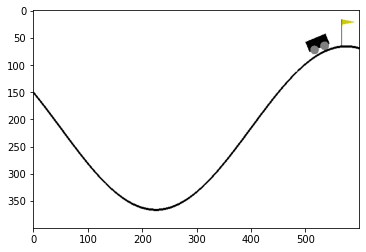

Q-value of the current state left=2398.27 nothing=2475.62 right=2544.92
Action: Right


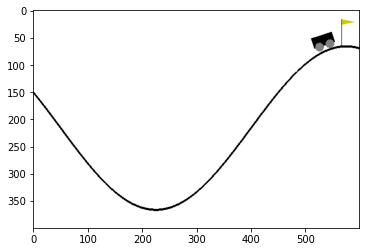

Q-value of the current state left=2496.43 nothing=2573.47 right=2641.81
Action: Right


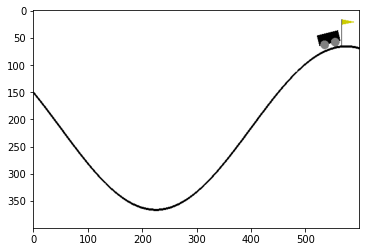

Q-value of the current state left=2595.54 nothing=2672.79 right=2741.02
Action: Right


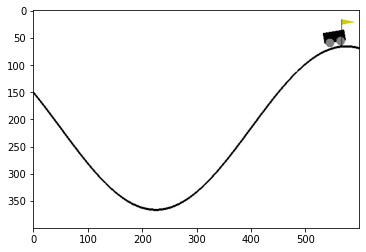

Q-value of the current state left=2702.62 nothing=2779.40 right=2847.71
Action: Right


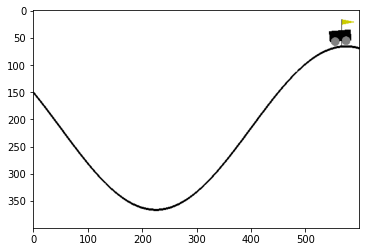

Q-value of the current state left=2819.94 nothing=2894.93 right=2963.02
Action: Right


In [22]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_model, obs)

    # Take greedy-action
    action, _ = dqn_model.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, done, info = env.step(action)

    episode_rewards.append(reward)


### Exercise (3 minutes): compare estimated initial q-value with actual discounted return

Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor `dqn_model.gamma`

In [23]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor

count = 0
for reward in episode_rewards:
  reward = reward * (dqn_model.gamma**count)
  sum_discounted_rewards += reward
  count = count + 1

### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -64.48, initial q-value -34.36


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [24]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = th.argmax(next_q_values_online, dim=1)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online.unsqueeze(-1))
               
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.huber_loss(target_q_values, current_q_values)

            ### END OF YOUR CODE
            
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [25]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset() for _ in range(n_samples)])
    
    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [75]:
dqn_model = DQN("MlpPolicy",
            "MountainCar-v0",
            verbose=0,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=2)

In [76]:
# Evaluate agent before training

mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


Define the callback

In [77]:
monitor_dqn_value_cb = MonitorQValueCallback()

In [78]:
dqn_model.learn(total_timesteps=int(1.2e5), callback=monitor_dqn_value_cb)

### Double DQN

In [79]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=0,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=2)

In [80]:
# Evaluate agent before training

mean_reward, std_reward = evaluate_policy(double_q, double_q.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [81]:
monitor_double_q_value_cb = MonitorQValueCallback()

In [82]:
double_q.learn(int(1.2e5), log_interval=10, callback=monitor_double_q_value_cb)

### Evolution of the max q-value for start states over time

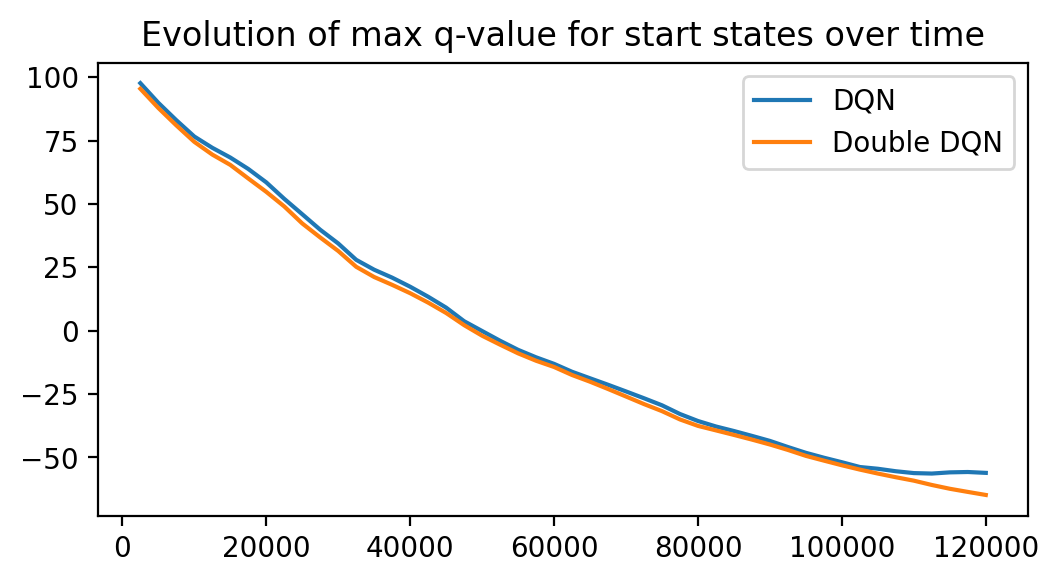

In [83]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()

## Comparing The Performance Between DQN and DDQN For Mountain Car Game

In [84]:
#Evaluate vanilla DQN model after training
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward of DQN after training:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward of DQN after training:-110.25 +/- 26.76


In [86]:
#Evaluate DDQN model after training
mean_reward, std_reward = evaluate_policy(double_q, double_q.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward of DDQN after training:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward of DDQN after training:-200.00 +/- 0.00


We can observe that Double DQN consistently produces lower values compared to DQN, which is what we'd expect since DQN has the tendency to overestimate the rewards. Interestingly, the Double DQN has not improved much after training while the DQN model has increased rewards by ~50%. However, we'd want to tune the hyperparameters (number of episodes, learning rate) further to get a more accurate understanding of the differences in their rewards.